# Solving Simflied Thick Ptychography Model Least Squares Problem

This tutorial demonstrates how to use `thick_ptycho` to set up and solve a least_squares problem to reconstuct a thick sample.

The wave inversion is posed as a least-squares problem:

\begin{equation}
E(n) = \frac{1}{2} \sum_{i=1}^{N} \| p_i(n) - p_{\text{obs},i} \|^2_2,
\end{equation}

where $p_i$ and $p_{\text{obs},i}$ are the simulated and observed exit waves for the $i$-th probe position in Ptychography. 

$n(x,z)$ defines the refractive index of the volume

### 1. Import Libraries: Sample Space, Least Squares Solver and Visualisation

In [12]:
from thick_ptycho.sample_space.sample_space import SampleSpace
from thick_ptycho.reconstruction.least_squares import LeastSquaresSolver
from thick_ptycho.utils.visualisations import Visualisation

import numpy as np

### 2. Set Simulation Parameters

Choose boundary conditions, probe type, and define the spatial domain and discretization.

In [13]:
bc_type = "impedance"     # Boundary condition type 
probe_type = "airy_disk"                 # Disk probe

# Constants
wavelength = 0.635e-6   # meters
k0 = 2 * np.pi / wavelength  # wavenumber [1/m]

# Background refractive index
nb = 1.0  # soft tissue approx. in vacuum

# Refractive index perturbation for soft tissue
delta = 0.01
beta = 0.001
refractive_index_perturbation = - delta - beta*1j 

# Spatial dimensions
xlims = [0.0, 150e-6]   # meters (sample width)
zlims = [0.0, 150e-6]   # meters (sample thickness)
continuous_dimensions = [xlims, zlims]


# Choose nz to satisfy paraxial resolution:
# Use approx. λ/4 axial resolution → ∆z ≈ λ / 4 ≈ 0.125 μm → nz = (z_range / ∆z)
z_range = zlims[1] - zlims[0]
dz = wavelength / 2
nz = int(z_range / dz)  
print(f"{nz=}")

# Discrete space parameters
probe_dimensions = [40]             # Discrete Probe dimensions
probe_diameter = int(0.8 * min(probe_dimensions))
scan_points = 124  # image planes
step_size = 3   

probe_angles_list = [0.0]               # Step size in pixels
probe_focus =  -0.00001 # focal length [m]

# Discrete space limits (pixels)
min_nx = int(scan_points * step_size + probe_dimensions[0])
print(f"{min_nx=}")
# Number of pixels in x directions
nx= nz
if nx < min_nx:
    nx = min_nx
discrete_dimensions = [
    nx,
    nz
    ]   

nz=472
min_nx=412


### 3. Create Sample Space, Add Objects and Visualise it.

Add rectangles with specified refractive indices to the sample space.

In [14]:
sample_space = SampleSpace(
    continuous_dimensions,   # meters
    discrete_dimensions,     # pixels (nx, nz)
    probe_dimensions,        # detector/probe window (pixels)
    scan_points,             # number of scan positions
    step_size,
    bc_type,                 # impedance / dirichlet / neumann
    probe_type,
    k0,                      # wavenumber [1/m]
    probe_diameter=probe_diameter,
    probe_focus=probe_focus,        
    n_medium=nb,
)

sample_space.summarize_sample_space()
visualisation = Visualisation(sample_space)

=== Scan Summary (Continuous) ===
  Sample space (x-range): 1.500e-04 m
  Sample space (z-range): 1.500e-04 m
  Probe diameter:         1.019e-05 m
  Number of scan points:  124
  Max Overlap:            9.236e-06 m
  Percentage Overlap:     90.62%



In [15]:
import numpy as np
gaussian_blur = 3

# Add 6 spheres of varying diameters and positions
common_side_length = 0.05*xlims[1]  # μm diameter
common_depth = 0.05*zlims[1]  # μm depth

sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,  # μm diameter
                        centre=(100/300*xlims[1], 100/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(150/300*xlims[1], 200/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
# sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
#                         centre=(200/300*xlims[1], 220/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(220/300*xlims[1], 200/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(125/300*xlims[1], 150/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(175/300*xlims[1], 100/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)
sample_space.add_object('circle', refractive_index_perturbation, side_length=common_side_length,
                        centre=(100/300*xlims[1], 220/300*zlims[1]), depth=common_depth, gaussian_blur=gaussian_blur)

sample_space.generate_sample_space()

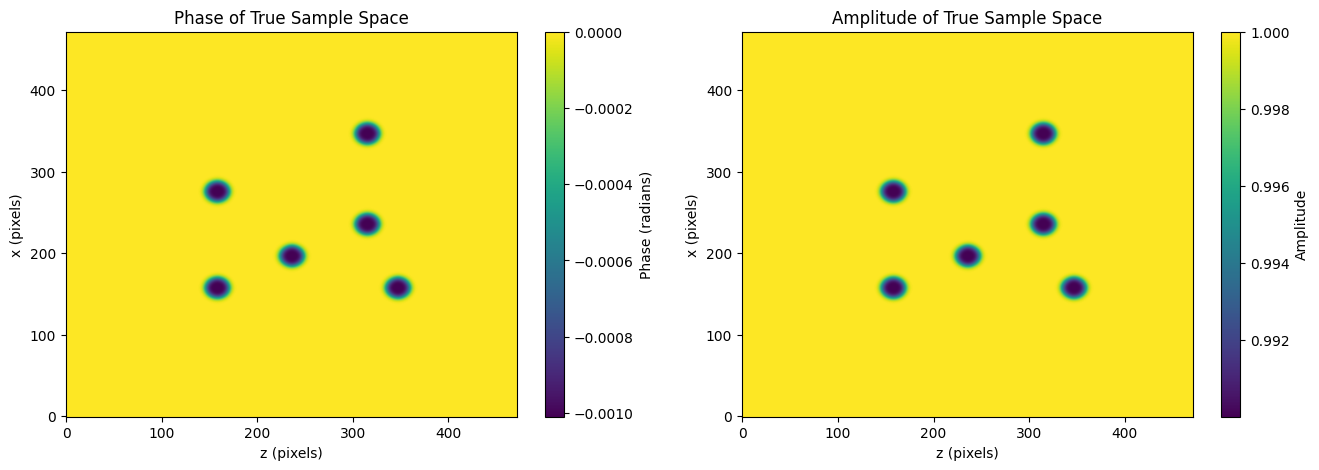

In [16]:
# Plot the true sample space
title = "True Sample Space"
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

true_phase = np.angle(sample_space.n_true)
true_amplitude = np.abs(sample_space.n_true)
vmin_phase = np.min(true_phase)
vmax_phase = np.max(true_phase)
vmin_amp = np.min(true_amplitude)
vmax_amp = np.max(true_amplitude)

# Get min and max values from the true sample space for color scaling
axs[0].set_title("Phase of True Sample Space")
im0 = axs[0].imshow(true_phase, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_phase, vmax=vmax_phase)
axs[0].set_xlabel('z (pixels)')
axs[0].set_ylabel('x (pixels)')
fig.colorbar(im0, ax=axs[0], label='Phase (radians)')

# Amplitude subplot
axs[1].set_title("Amplitude of True Sample Space")
im1 = axs[1].imshow(true_amplitude, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_amp, vmax=vmax_amp)
axs[1].set_xlabel('z (pixels)')
axs[1].set_ylabel('x (pixels)')
fig.colorbar(im1, ax=axs[1], label='Amplitude')

### 6. Solve Least Squares to Reconstruct Simulated Sample Space


Initializing Least Squares Solver...
Solving the true forward problem once to generate the dataset...
True Object


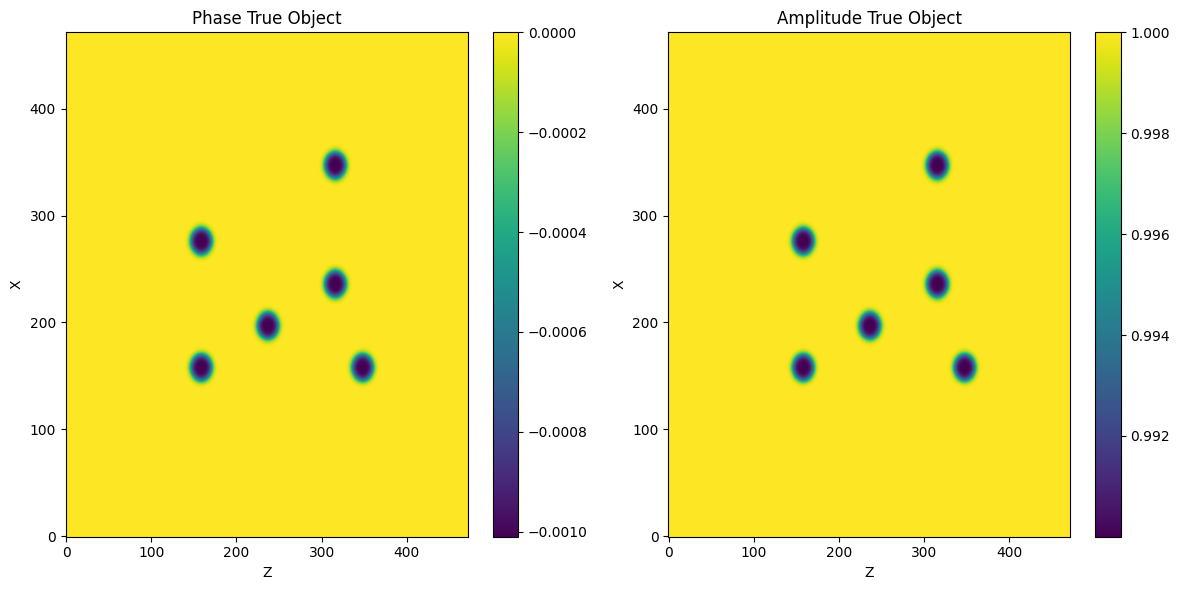

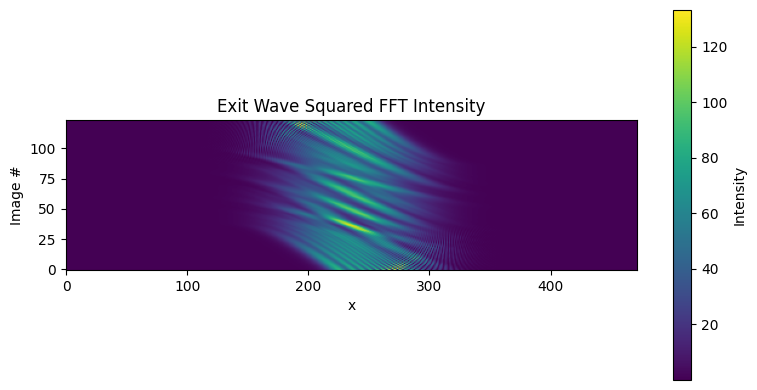

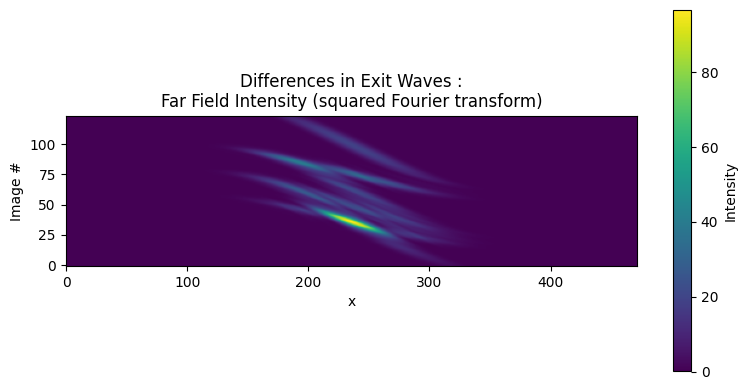

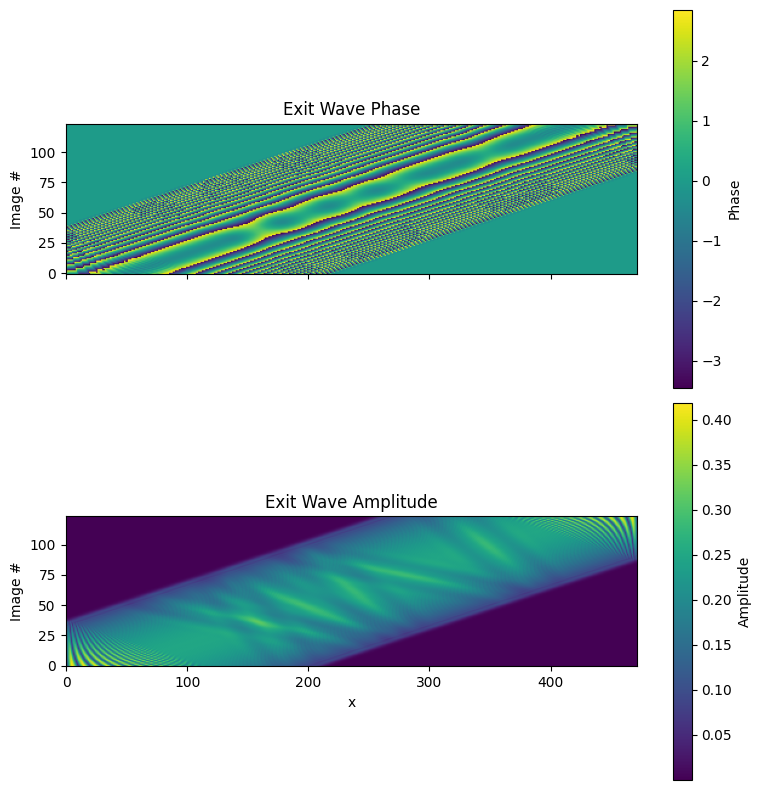

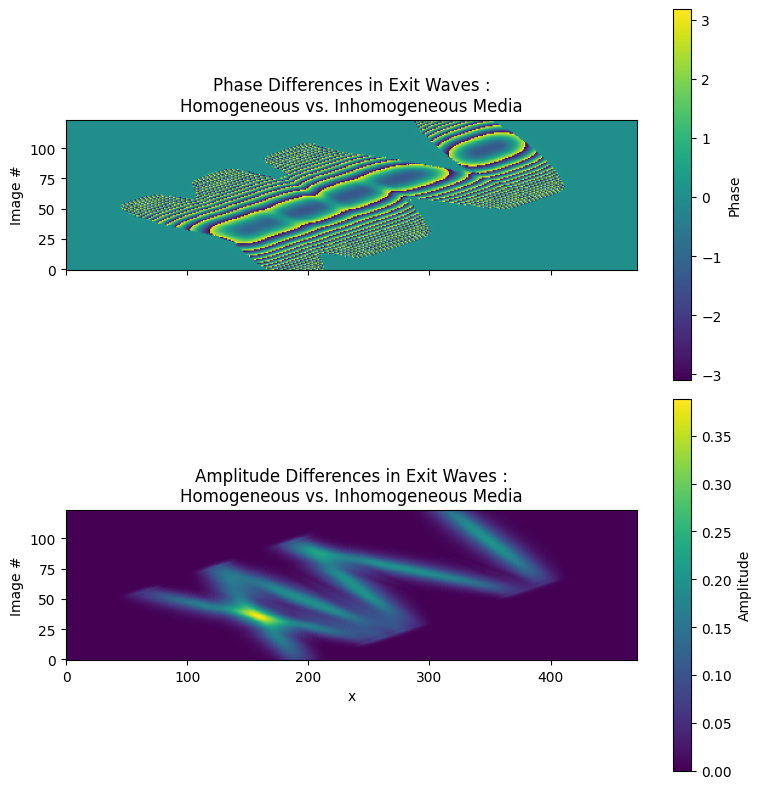

True Object


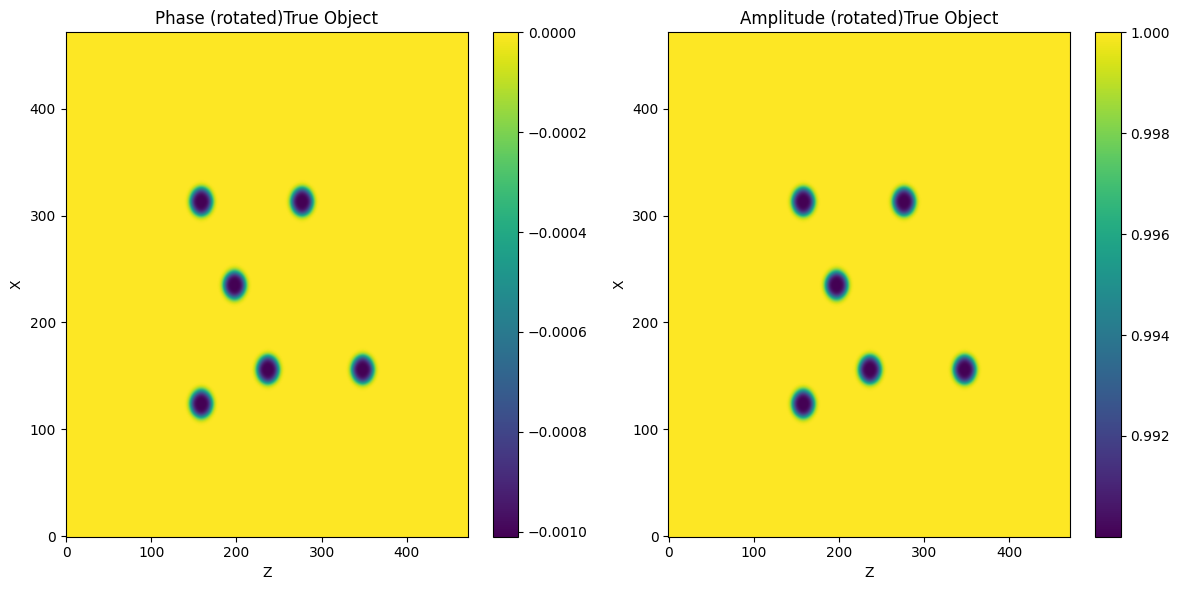

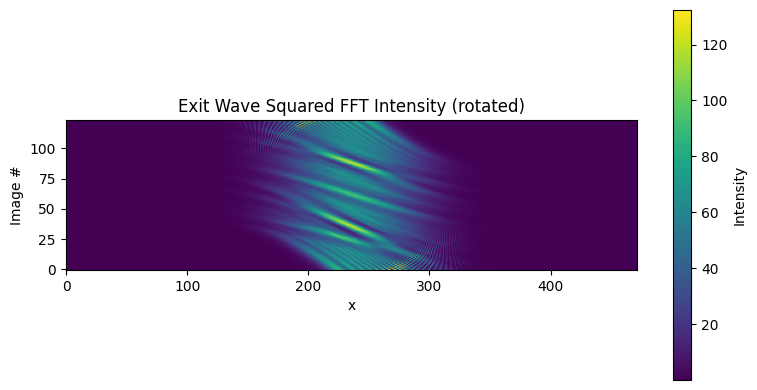

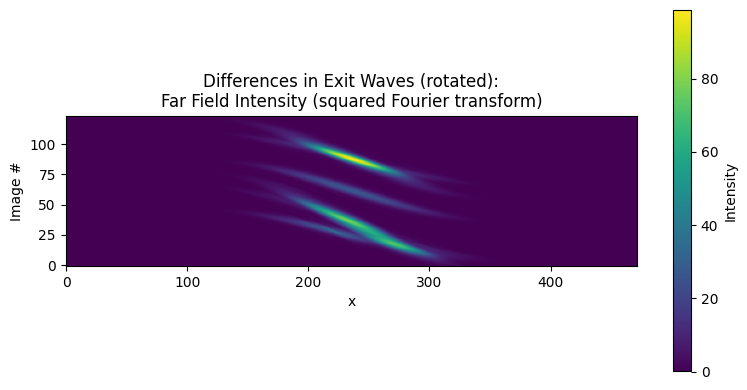

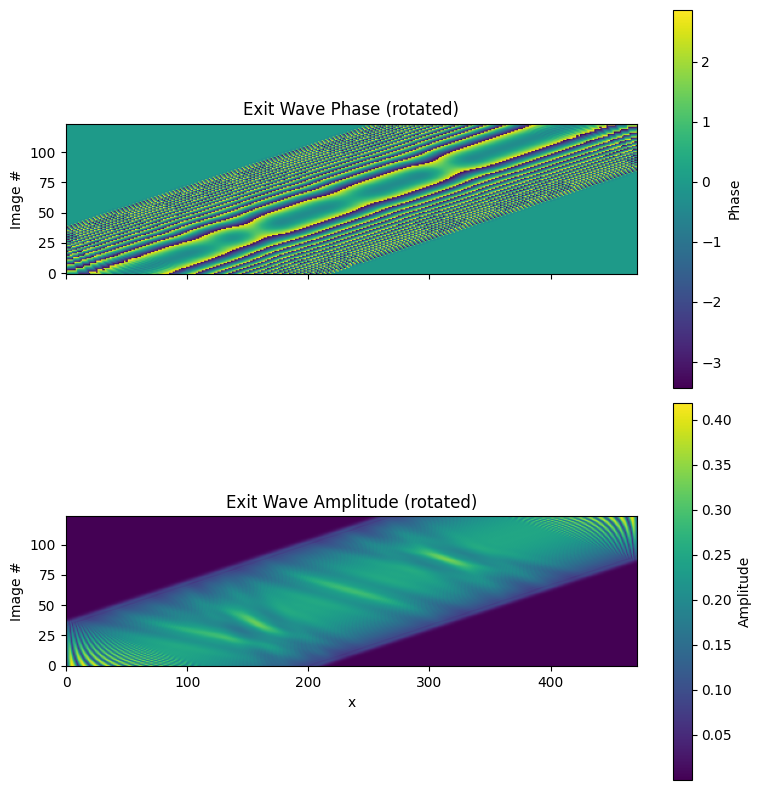

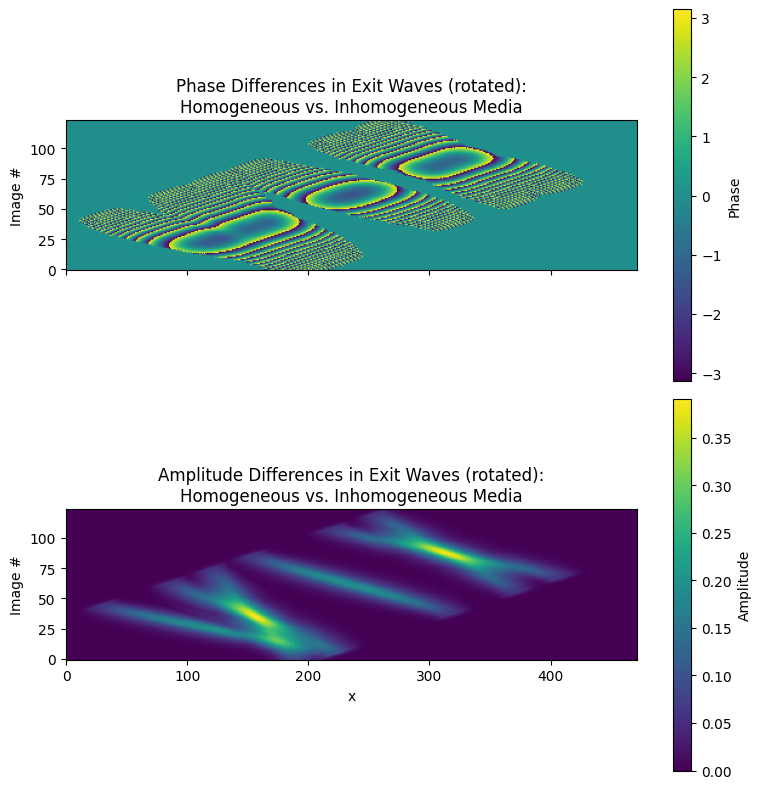

True Forward Solution computed in 11.60 seconds.
Angle 0.0


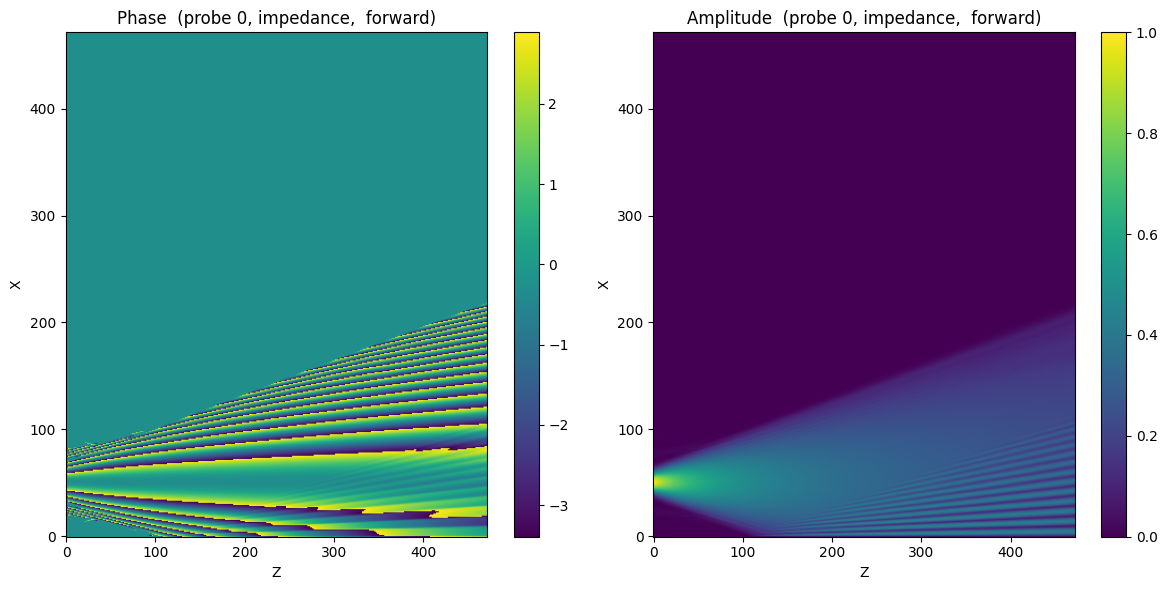

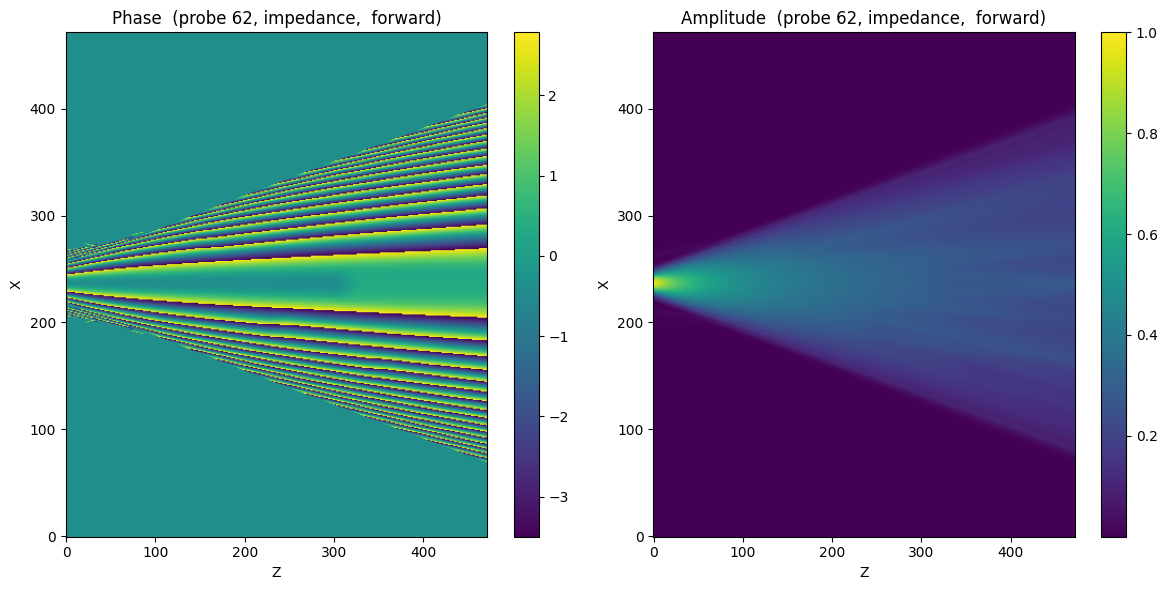

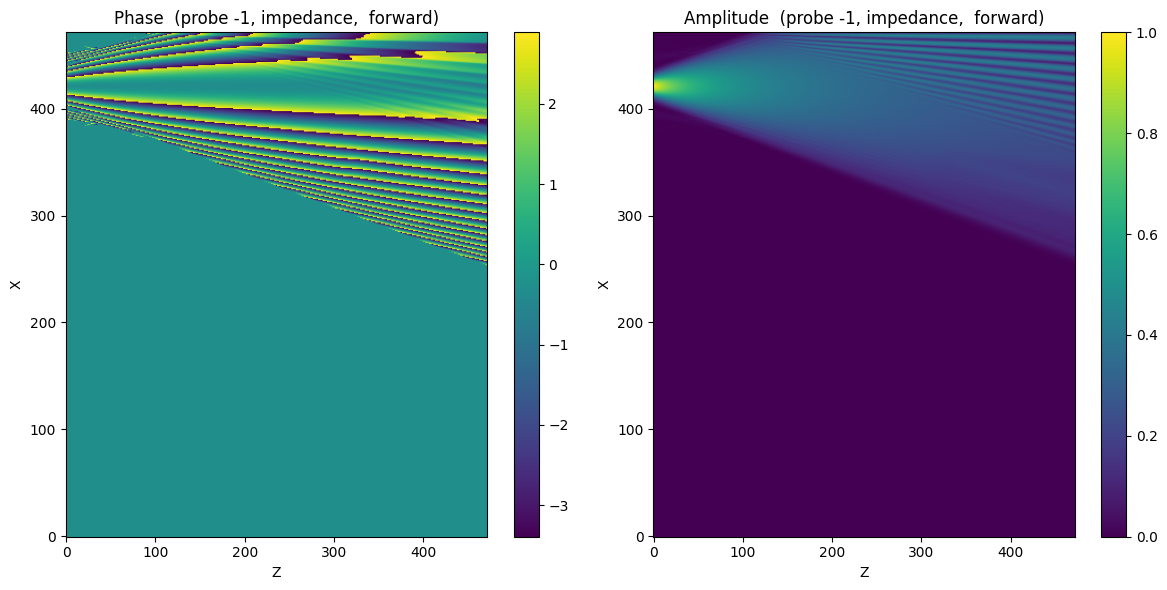

In [17]:
# Solve full system all-at-once or iteratively
least_squares = LeastSquaresSolver(sample_space,full_system_solver=False,probe_angles_list=probe_angles_list)

True Object


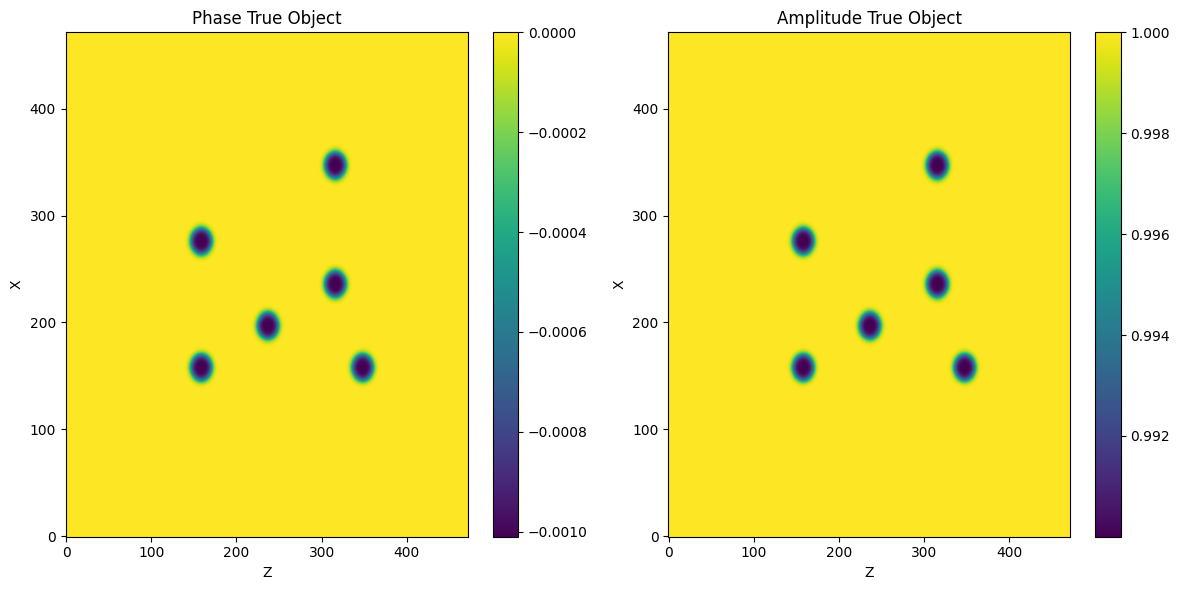

In [ ]:
max_iters = 10
reconstructed_sample_space, reconstructed_wave, residual_history = (
    least_squares.solve(max_iters=max_iters,
                        plot_forward=False,
                        plot_reverse=False,
                        plot_object=True,
                        solve_probe=False,
                        sparsity_lambda=0.00002,
                        low_pass_filter=0.0)
)

# %load_ext line_profiler
# target_method = least_squares.solve
# %lprun -f target_method least_squares.solve(max_iters=max_iters,plot_forward=False, plot_reverse=False,plot_object=True,fixed_step_size=None,solve_probe=True,sparsity_lambda=0.0)#0.00002)


### 7. Visualise the Residual History and Final Iterations

Residual History of Least Squares Objective Function


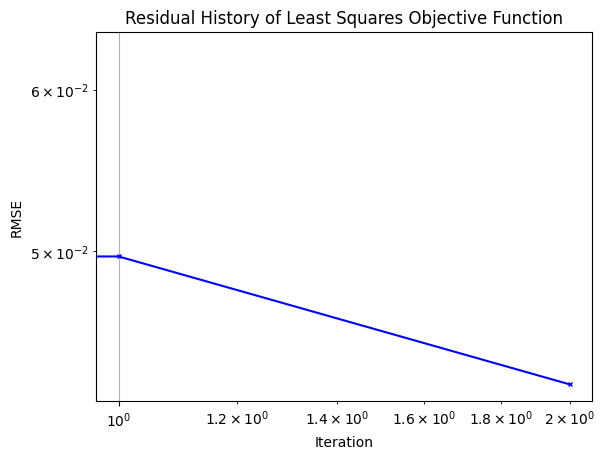

In [ ]:
import matplotlib.pyplot as plt

# Log-log plot of residual
title ='Residual History of Least Squares Objective Function'
print(title)
plt.figure()
plt.loglog(residual_history, marker='x', linestyle='-', color='b',markersize=3)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title(title)
plt.grid(True)
plt.show()

Reconstructed Sample Space


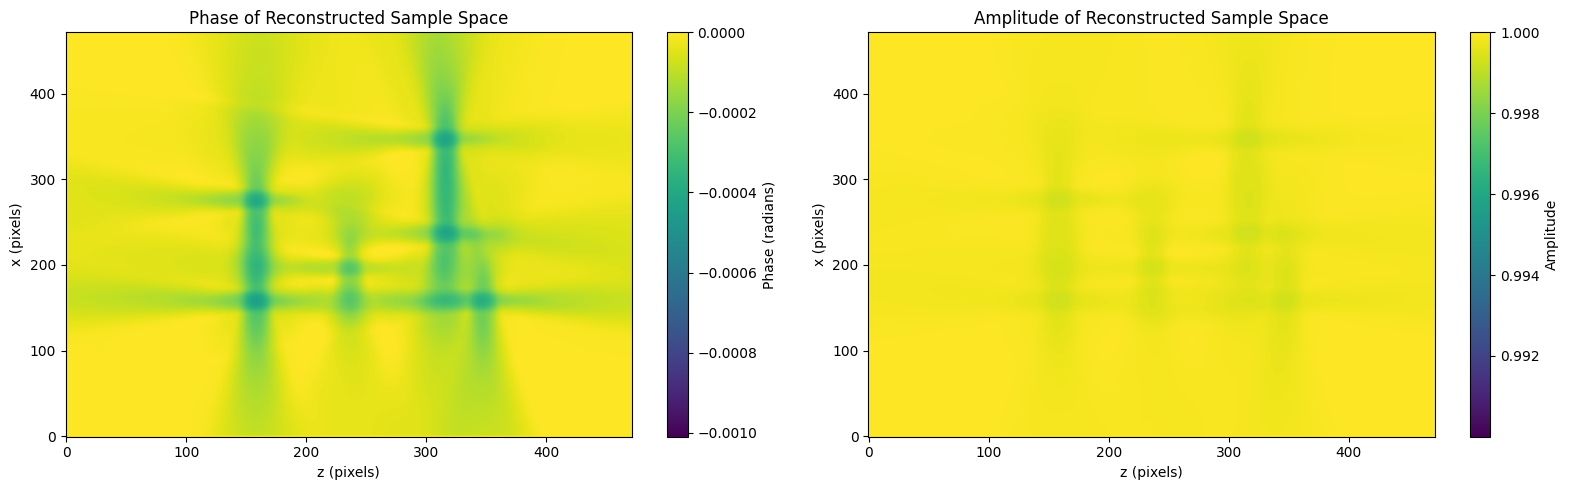

In [ ]:
# Plot object field
title = "Reconstructed Sample Space"
print(title)

# Plot phase and amplitude of reconstructed sample space using subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Get min and max values from the true sample space for color scaling
true_phase = np.angle(sample_space.n_true)
true_amplitude = np.abs(sample_space.n_true)
phase = np.angle(reconstructed_sample_space)
amplitude = np.abs(reconstructed_sample_space)
vmin_phase = np.min(true_phase)
vmax_phase = np.max(true_phase)
vmin_amp = np.min(true_amplitude)
vmax_amp = np.max(true_amplitude)

# Phase subplot
axs[0].set_title("Phase of Reconstructed Sample Space")
im0 = axs[0].imshow(phase, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_phase, vmax=vmax_phase)
axs[0].set_xlabel('z (pixels)')
axs[0].set_ylabel('x (pixels)')
fig.colorbar(im0, ax=axs[0], label='Phase (radians)')

# Amplitude subplot
axs[1].set_title("Amplitude of Reconstructed Sample Space")
im1 = axs[1].imshow(amplitude, origin='lower', aspect='auto', cmap='viridis', vmin=vmin_amp, vmax=vmax_amp)
axs[1].set_xlabel('z (pixels)')
axs[1].set_ylabel('x (pixels)')
fig.colorbar(im1, ax=axs[1], label='Amplitude')

plt.tight_layout()
plt.show()


Reconstructed Wave


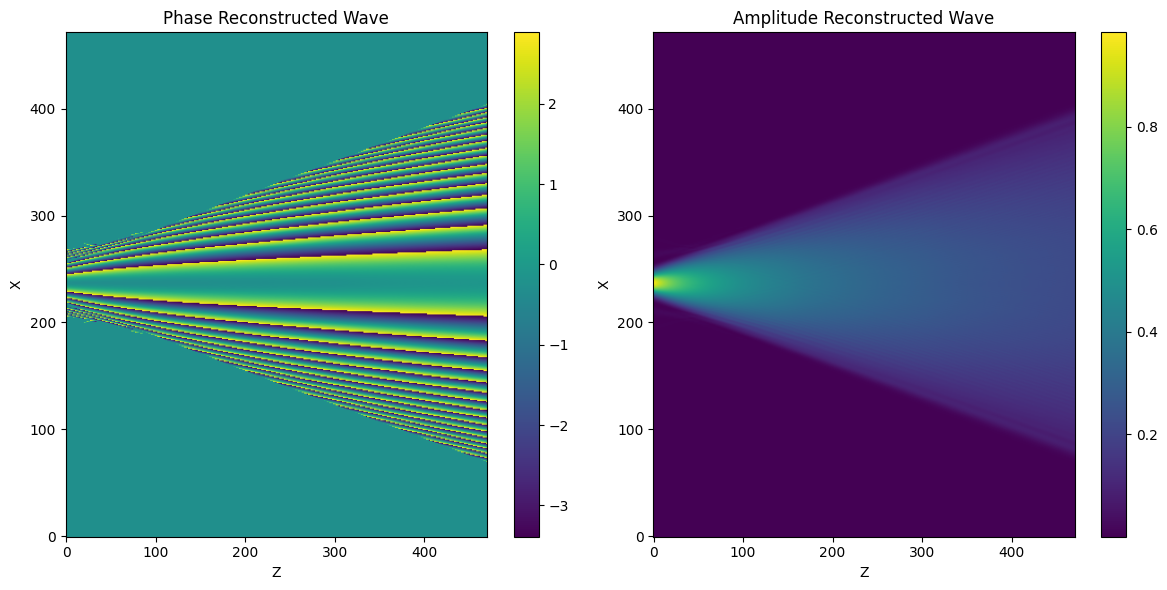

In [ ]:
# Plot the reconstructed wave
title = "Reconstructed Wave"
print(title)
visualisation.plot(reconstructed_wave[0], title=title)
# visualisation.plot(reconstructed_wave[int(num_angles/2)], title=title)
# visualisation.plot(reconstructed_wave[-1], title=title)

In [ ]:
# Profile the reconstruction
# %load_ext line_profiler
# %lprun -f SolveLeastSquares.compute_forward_model least_squares.solve(max_iters=max_iters, plot_forward=True, plot_object=True, fixed_step_size=False)
